# Balls and Strikes Effects

## 6.2 Hitter’s Counts and Pitcher’s Counts

### 6.2.1 An example for a single pitcher

In [2]:
import pandas as pd
import numpy as np

balls = np.repeat([0, 1, 2, 3], 3)
strikes = np.tile([0, 1, 2], 4)

mussina = pd.DataFrame({
    'balls': balls,
    'strikes': strikes,
    'value': [
        100, 72, 30, 118, 82, 38,
        157, 114, 64, 207, 171, 122
    ]
})
mussina

,balls,strikes,value
0,0,0,100
1,0,1,72
2,0,2,30
3,1,0,118
4,1,1,82
5,1,2,38
6,2,0,157
7,2,1,114
8,2,2,64
9,3,0,207


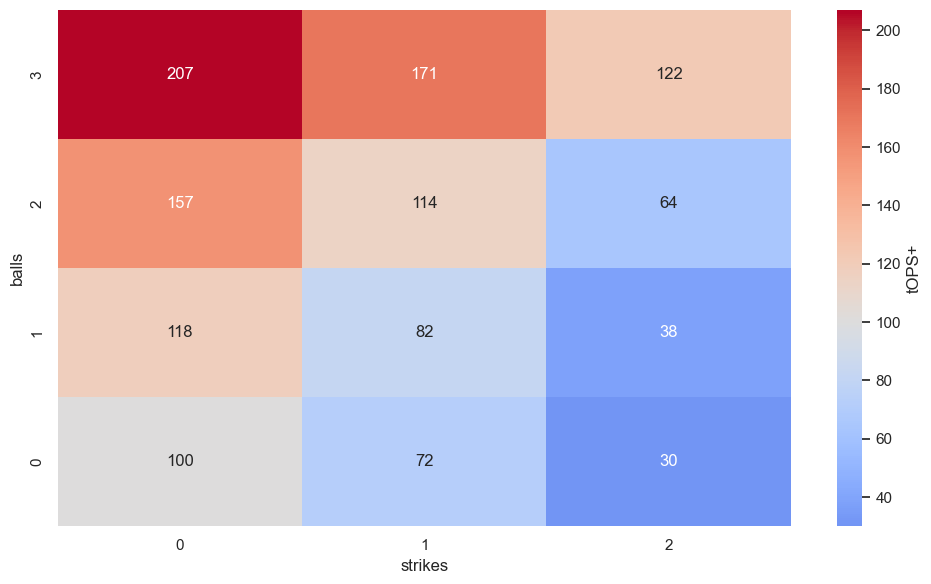

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table for heatmap
pivot_data = mussina.pivot(index='balls', columns='strikes', values='value')

# Create heatmap with seaborn's diverging palette
sns.heatmap(
    pivot_data,
    annot=True,
    fmt='g',
    cmap='coolwarm',
    center=100,
    cbar_kws={'label': 'tOPS+'},
    ax=ax
)

# Invert y-axis
ax.invert_yaxis()

# Labels
ax.set_xlabel('strikes')
ax.set_ylabel('balls')

plt.tight_layout()
plt.show()
